In [ ]:
from datetime import datetime

# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta

# from pmdarima.arima import auto_arima
from sklearn.metrics import root_mean_squared_error
import pickle
from pmdarima.arima import auto_arima

In [ ]:
df = pd.read_csv("../dataset.csv", index_col="ts", parse_dates=True)
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


In [ ]:
df = df.resample("6H").mean()
df.head()

/tmp/ipykernel_65302/291736663.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('6H').mean()


,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 18:00:00,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02 00:00:00,13.0,22.453833,33.401067,3192.000000,86.000000,28.300000,0.000000,72.000000
2025-04-02 06:00:00,23.5,26.436983,33.516494,3200.916667,65.722222,31.611111,0.000000,55.777778
2025-04-02 12:00:00,44.5,24.979783,33.541017,3151.187500,44.000000,34.504167,0.000000,100.000000
2025-04-02 18:00:00,68.5,30.427021,34.188162,3130.416667,76.000000,29.166667,0.000000,100.000000


In [ ]:
train_end = datetime(2025, 4, 9)
test_end = datetime(2025, 4, 11)

train_data = df[: train_end - timedelta(days=1)]
test_data = df[train_end:test_end]

# Training sarima to predict the temperature 

## EDA

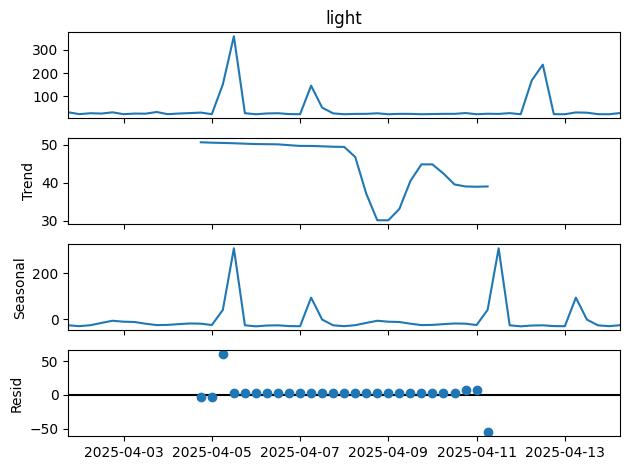

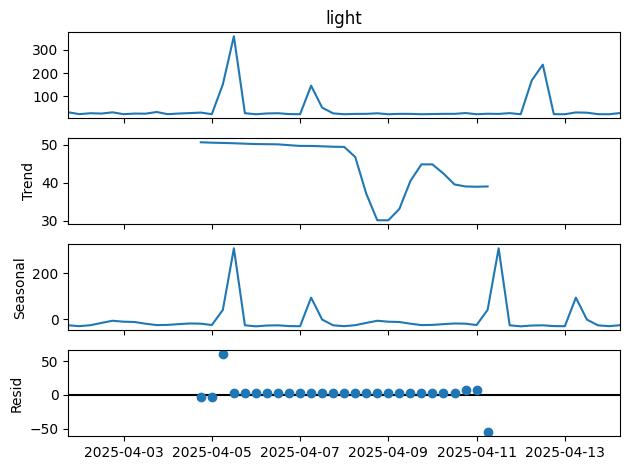

In [10]:
seasonal_decompose(df["light"].interpolate(), model="additive").plot()

### Find the D parameter

In [ ]:
result = adfuller(df["light"].dropna(), autolag="AIC")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

ADF Statistic: -4.9845935508555685
p-value: 2.380519453026214e-05
Critial Values:
   1%, -3.5745892596209488
Critial Values:
   5%, -2.9239543084490744
Critial Values:
   10%, -2.6000391840277777


The ADF statistics value is less than 0.05, therefore, it is stationary.

### Find the P parameter

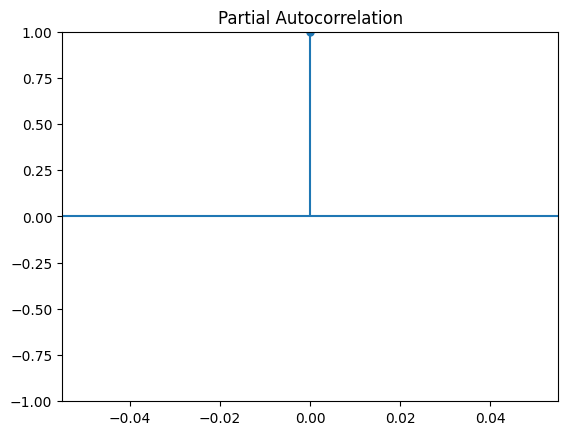

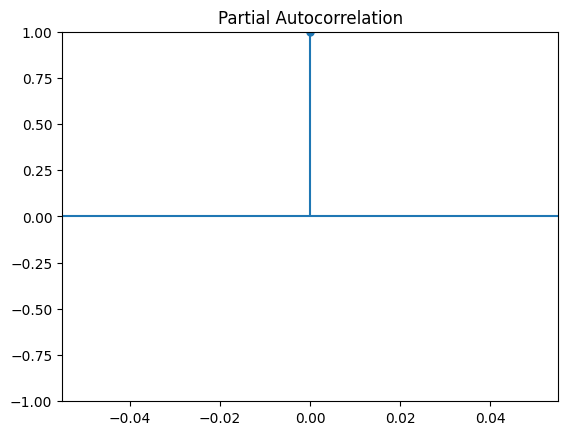

In [34]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["light"])

The two lags in the front are the most influential, therefore, p = 2

### Find the Q parameter

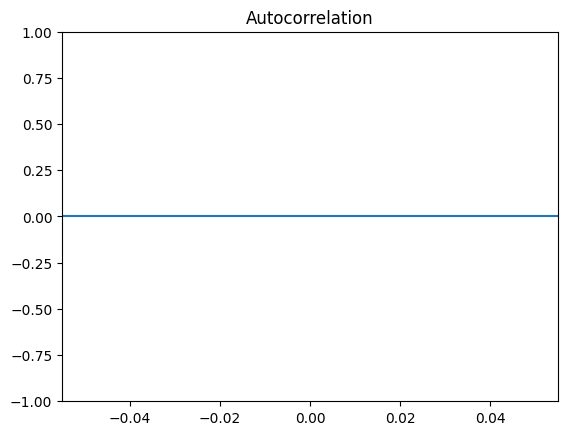

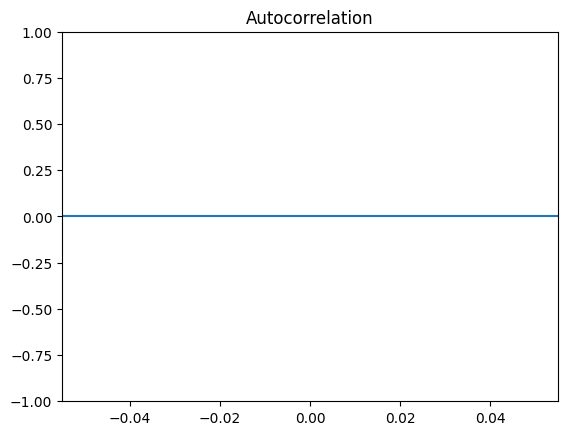

In [13]:
plot_acf(df["light"])

The graph is not clear, therefore, the q parameter might be 0 or 1

## Pre-Processing

Fill in missing light value (due to server outage)
Use ffill, which replace NULL values with the value from the previous row.

In [30]:
test_data["light"] = test_data["light"].ffill()

/tmp/ipykernel_65302/642008127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["light"] = test_data["light"].ffill()


## Train the model

In [31]:
# Use auto_arima to find the best model parameters
model = auto_arima(
    train_data["light"],
    seasonal=True,
    m=3,  # Seasonality settings
    d=0,
    D=0,
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[3] intercept   : AIC=306.221, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=298.976, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=301.440, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=300.851, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=307.136, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[3] intercept   : AIC=300.678, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[3] intercept   : AIC=300.566, Time=0.03 sec


/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(0,0,0)(1,0,1)[3] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[3] intercept   : AIC=299.556, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[3] intercept   : AIC=298.992, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[3] intercept   : AIC=300.443, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[3] intercept
Total fit time: 0.767 seconds


/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [32]:
model_temperature = SARIMAX(
    endog=train_data["light"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 3)
)
temperature_results = model_temperature.fit()

steps = len(test_data)

temperature_prediction = temperature_results.get_forecast(
    steps=steps
).predicted_mean
forecast_index = pd.date_range(
    start=test_data.index[0],
    freq=timedelta(days=1),
    periods=int(test_data["light"].count()),
)
temperature_prediction.index = test_data.index[:steps]
temperature_prediction.columns = ["predicted"]

/home/jang/ske/da/project-sarimax/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


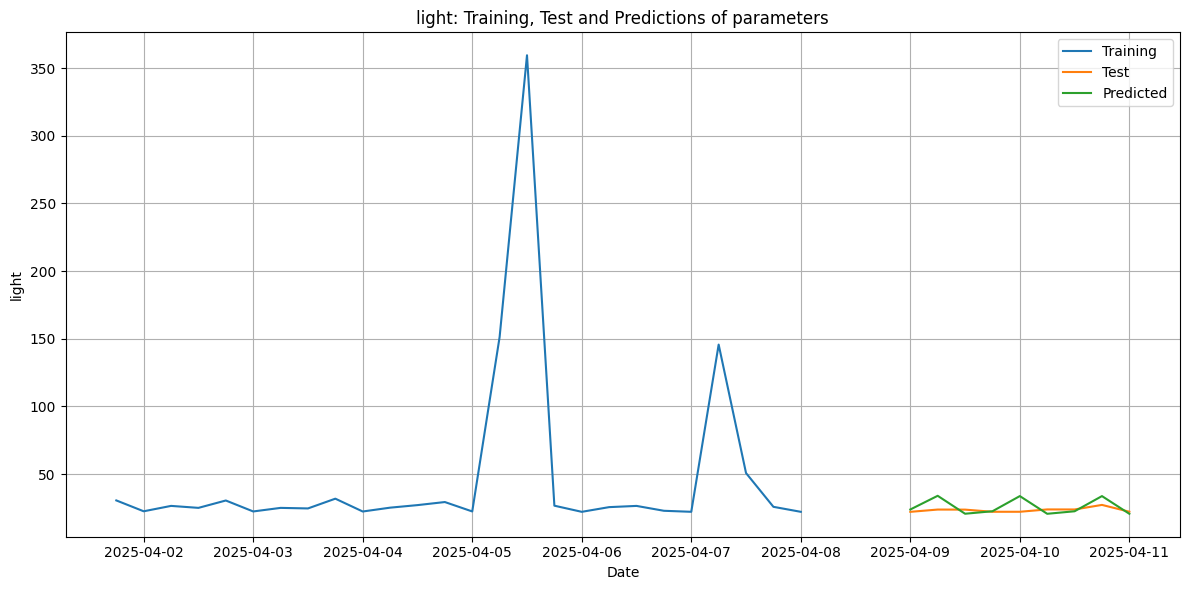

RMSE is :  5.841506279473765


In [33]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["light"], label="Training")
plt.plot(test_data.index, test_data["light"], label="Test")
plt.plot(test_data.index, temperature_prediction, label="Predicted")

plt.legend()
plt.xlabel("Date")
plt.ylabel("light")
plt.title("light: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE is : ", root_mean_squared_error(test_data["light"], temperature_prediction))

## Save the model using pickle

In [ ]:
with open("../exports/light_sarima.pkl", "wb") as file:
    pickle.dump(temperature_results, file)

# Training sarima to predict the precipitation 

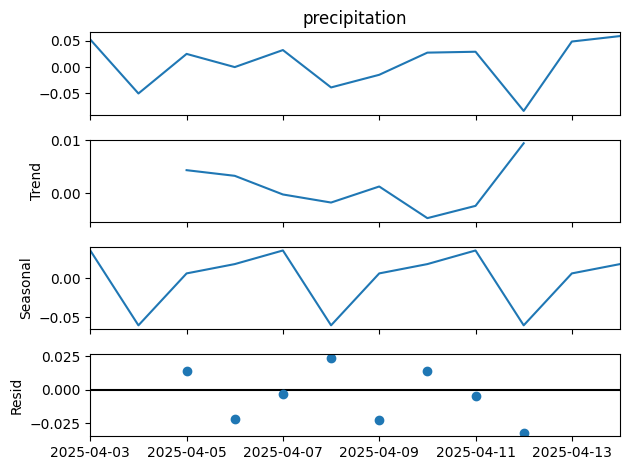

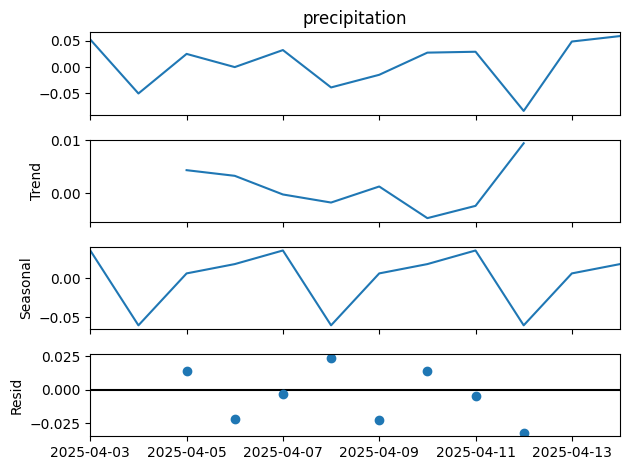

In [ ]:
seasonal_decompose(
    df["precipitation"].diff().dropna().diff().dropna(), model="additive", period=4
).plot()

## Find the D parameter

In [ ]:
result = adfuller(df["precipitation"].diff().dropna().diff().dropna(), autolag="AIC")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

ADF Statistic: -6.2637331603178295
p-value: 4.16264636489734e-08
Critial Values:
   1%, -4.473135048010974
Critial Values:
   5%, -3.28988060356653
Critial Values:
   10%, -2.7723823456790124


The model returns the p-value < 0.05, therefore, the d parameter must be 2.

## Find the P parameter

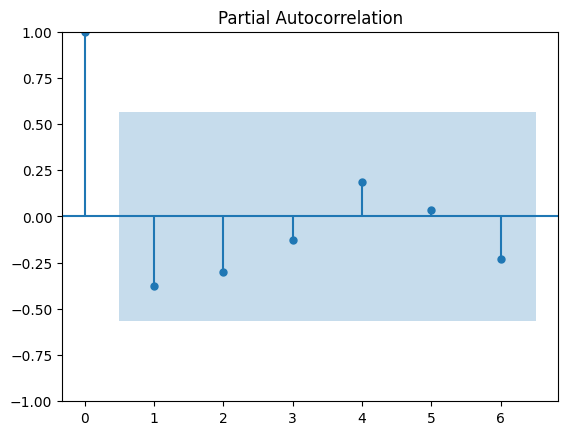

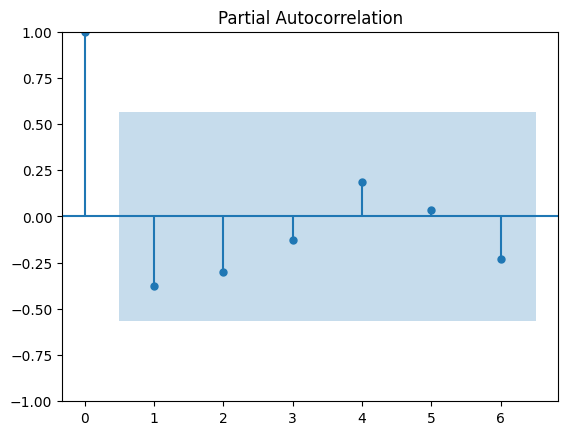

In [ ]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["humidity"].diff().dropna().diff().dropna())


The 4 lags in the front are the most influential, therefore, p = 4

## Find the Q parameter

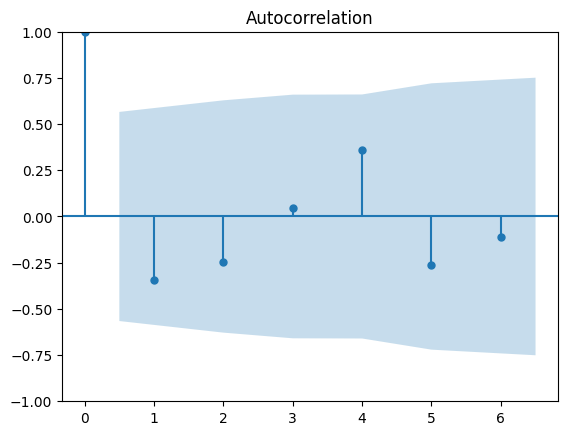

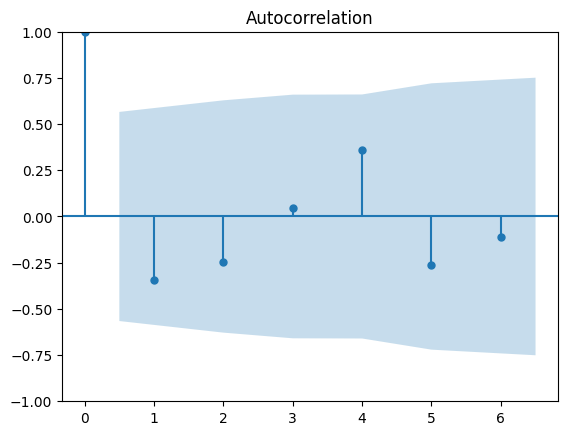

In [ ]:
plot_acf(df["precipitation"].diff().dropna().diff().dropna())

The graph is not clear, therefore, the q parameter might be 0 or 1

## Train the model

In [ ]:
# Use auto_arima to find the best model parameters
model = auto_arima(
    train_data["precipitation"],
    seasonal=True,
    m=4,  # seasonality
    d=1,
    D=1,
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=-10.720, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-13.090, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-10.280, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-9.311, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=-11.090, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-11.090, Time=0.06 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(0,1,0)(1,1,1)[4]             : AIC=-9.090, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-11.884, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-11.311, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=-16.318, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=-14.318, Time=0.04 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=-14.318, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=-12.318, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=-14.651, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=-16.196, Time=0.13 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=-15.763, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4] intercept
Total fit time: 1.204 seconds


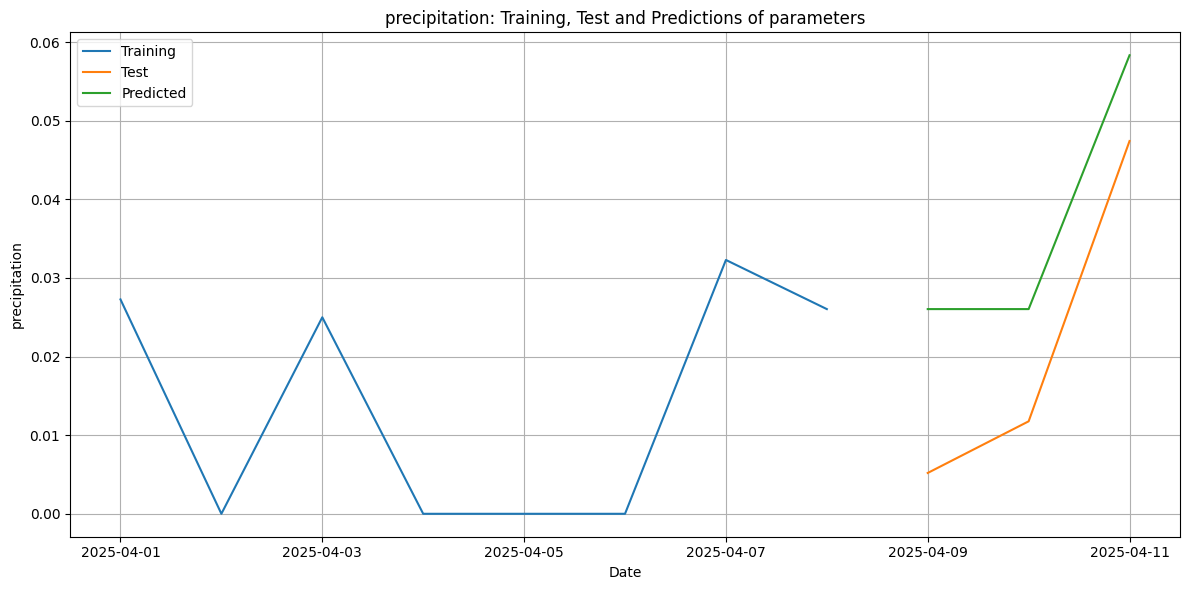

RMSE is :  0.01588989585951128


In [ ]:
model_humidity = SARIMAX(
    endog=train_data["precipitation"],
    order=model.order,  # (1,2,1),
    seasonal_order=model.seasonal_order,  # (1,2,1,4)
)
humidity_results = model_humidity.fit()

humidity_prediction = humidity_results.get_forecast(
    steps=int(test_data["precipitation"].count())
).predicted_mean
forecast_index = pd.date_range(
    start=test_data.index[0],
    freq=timedelta(days=1),
    periods=int(test_data["precipitation"].count()),
)
humidity_prediction.columns = ["predicted"]

plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["precipitation"], label="Training")
plt.plot(test_data.index, test_data["precipitation"], label="Test")
plt.plot(
    test_data.index, humidity_prediction, label="Predicted"
)  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("precipitation")
plt.title(f"precipitation: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print(
    f"RMSE is : ",
    root_mean_squared_error(test_data["precipitation"], humidity_prediction),
)

## Save the model using pickle

In [ ]:
with open("../exports/precipitation_sarima.pkl", "wb") as file:
    pickle.dump(humidity_results, file)

# Training sarima to predict the temperature 

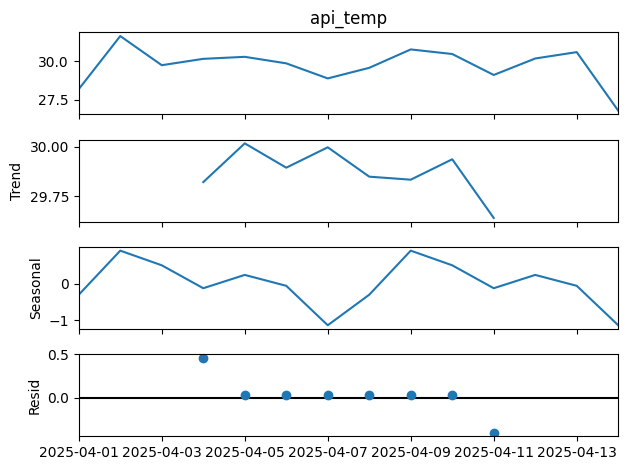

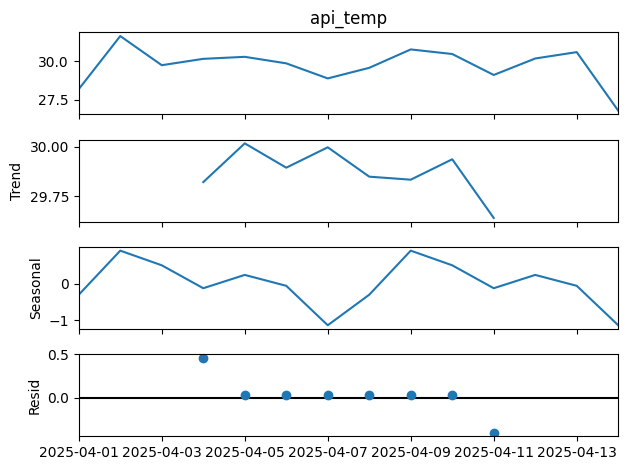

In [ ]:
seasonal_decompose(df["api_temp"], model="additive").plot()

## Find the D parameter

In [ ]:
result = adfuller(df["api_temp"].dropna(), autolag="AIC")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

ADF Statistic: -1.6046739772129046
p-value: 0.4812451879666485
Critial Values:
   1%, -4.473135048010974
Critial Values:
   5%, -3.28988060356653
Critial Values:
   10%, -2.7723823456790124


The ADF statistics value is less than 0.05, therefore, it is stationary.

## Find the P parameter

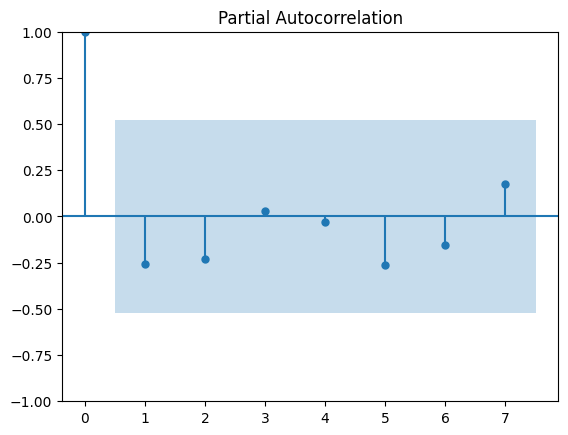

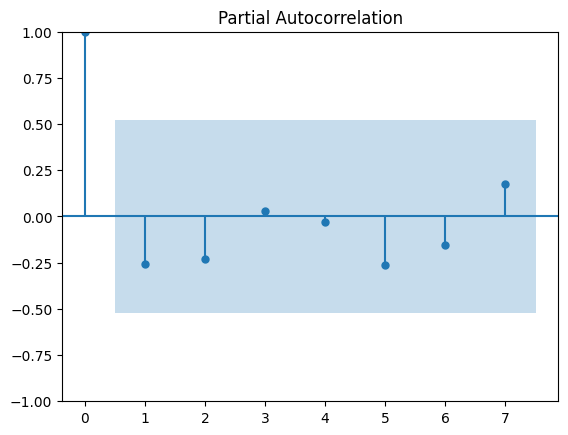

In [ ]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["api_temp"])

The three lags in the front are the most influential, therefore, p = 3

## Find the Q parameter

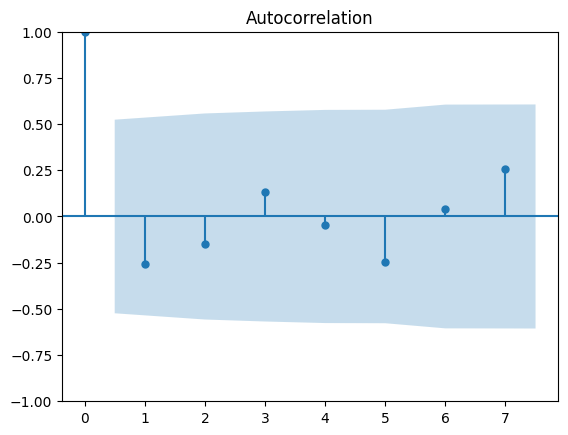

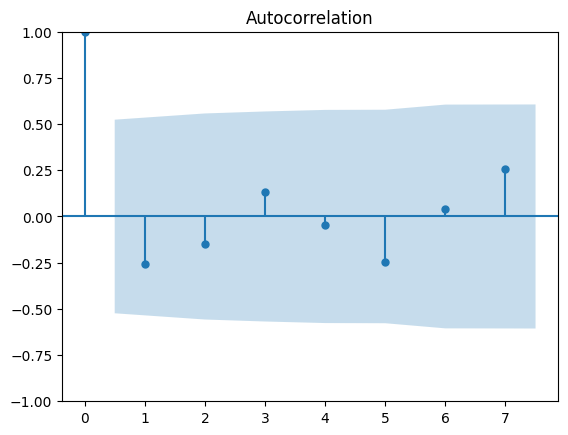

In [ ]:
plot_acf(df["api_temp"])

The graph is not clear, therefore, the q parameter might be 0 or 1

## Train the model

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2025-04-09    29.790924
2025-04-10    29.434394
2025-04-11    30.135636
Freq: D, Name: predicted_mean, dtype: float64


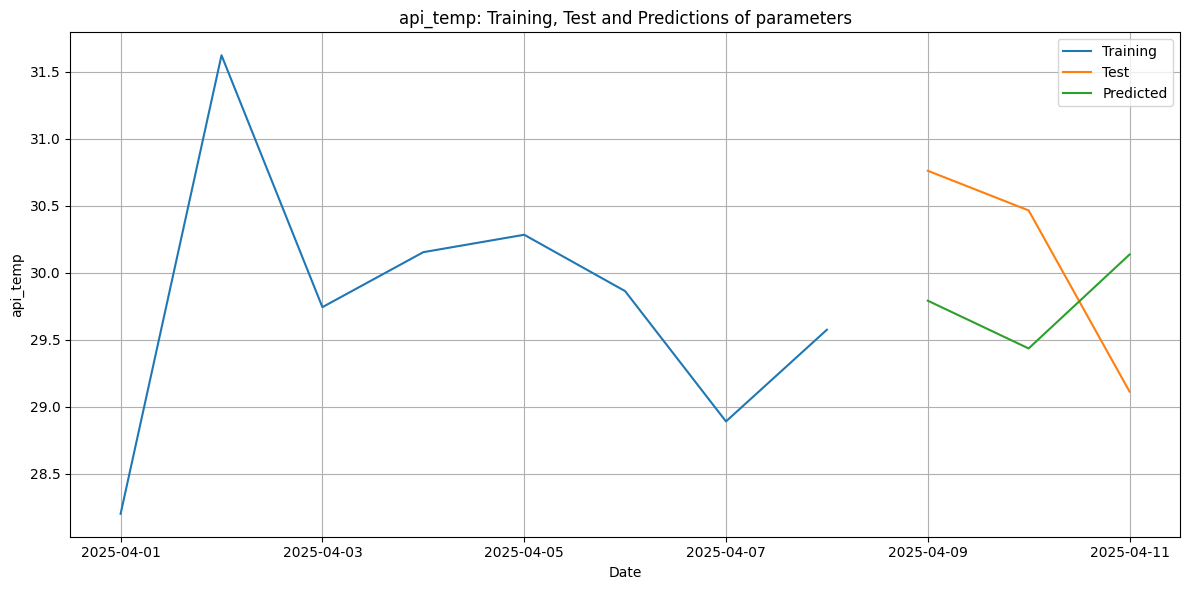

RMSE is :  1.0082553803579875


In [ ]:
model_api_temp = SARIMAX(
    endog=train_data["api_temp"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 3)
)
api_temp_results = model_api_temp.fit()

api_temp_prediction = api_temp_results.get_forecast(
    steps=int(test_data["api_temp"].count())
).predicted_mean
forecast_index = pd.date_range(
    start=test_data.index[0],
    freq=timedelta(days=1),
    periods=int(test_data["api_temp"].count()),
)
api_temp_prediction.columns = ["predicted"]

print(api_temp_prediction)

plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["api_temp"], label="Training")
plt.plot(test_data.index, test_data["api_temp"], label="Test")
plt.plot(
    test_data.index, api_temp_prediction, label="Predicted"
)  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("api_temp")
plt.title("api_temp: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE is : ", root_mean_squared_error(test_data["api_temp"], api_temp_prediction))

## Save the model using pickle

In [ ]:
with open("../exports/api_temp_sarima.pkl", "wb") as file:
    pickle.dump(api_temp_results, file)